In [5]:
import pandas as pd

df = pd.read_csv("/kaggle/input/supervisely-filtered-segmentation-person-dataset/df.csv")

In [10]:
import os
image_dir = '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img'
mask_dir = '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img'

df['image_path'] = df['images'].apply(lambda x: os.path.join(image_dir, x))
df['mask_path'] = df['masks'].apply(lambda x: os.path.join(mask_dir, x))

print(df[['image_path', 'mask_path']].head())

df['image_path'][0]

                                          image_path  \
0  /kaggle/input/supervisely-filtered-segmentatio...   
1  /kaggle/input/supervisely-filtered-segmentatio...   
2  /kaggle/input/supervisely-filtered-segmentatio...   
3  /kaggle/input/supervisely-filtered-segmentatio...   
4  /kaggle/input/supervisely-filtered-segmentatio...   

                                           mask_path  
0  /kaggle/input/supervisely-filtered-segmentatio...  
1  /kaggle/input/supervisely-filtered-segmentatio...  
2  /kaggle/input/supervisely-filtered-segmentatio...  
3  /kaggle/input/supervisely-filtered-segmentatio...  
4  /kaggle/input/supervisely-filtered-segmentatio...  


'/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images/ds10_pexels-photo-687782.png'

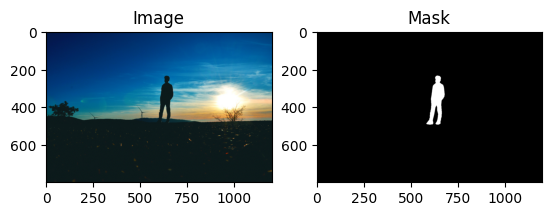

In [21]:
import cv2
import numpy as np

def load_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255.0
    
    return image, mask

image, mask = load_image_and_mask(df['image_path'][0], df['mask_path'][0])

import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.show()


In [22]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f'Eğitim seti boyutu: {len(train_df)}')
print(f'Doğrulama seti boyutu: {len(val_df)}')

Eğitim seti boyutu: 2133
Doğrulama seti boyutu: 534


In [23]:
from tensorflow.keras.utils import Sequence
import os

In [24]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, dim=(256, 256), n_channels=3, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.dataframe.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = []
        masks = []
        
        for i in range(len(batch_df)):
            image, mask = load_image_and_mask(batch_df['image_path'].iloc[i], batch_df['mask_path'].iloc[i])
            image = cv2.resize(image, self.dim)
            mask = cv2.resize(mask, self.dim)
            
            images.append(image)
            masks.append(mask)
        
        return np.array(images), np.array(masks)

train_generator = DataGenerator(train_df, batch_size=16)
val_generator = DataGenerator(val_df, batch_size=16)

In [25]:
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    # Bottleneck
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    
    # Decoder
    up1 = layers.UpSampling2D((2, 2))(conv4)
    up1 = layers.concatenate([up1, conv3], axis=-1)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up1)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    
    up2 = layers.UpSampling2D((2, 2))(conv5)
    up2 = layers.concatenate([up2, conv2], axis=-1)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    
    up3 = layers.UpSampling2D((2, 2))(conv6)
    up3 = layers.concatenate([up3, conv1], axis=-1)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = models.Model(inputs, outputs)
    return model


In [26]:
model = unet_model(input_size=(256, 256, 3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, 
                    epochs=25, #You can change epochs 
                    validation_data=val_generator)

Epoch 1/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.7684 - loss: 0.4792 - val_accuracy: 0.7821 - val_loss: 0.4565
Epoch 2/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7861 - loss: 0.4462 - val_accuracy: 0.7923 - val_loss: 0.4425
Epoch 3/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8098 - loss: 0.4090 - val_accuracy: 0.7999 - val_loss: 0.4190
Epoch 4/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.8208 - loss: 0.3933 - val_accuracy: 0.7962 - val_loss: 0.4309
Epoch 5/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8219 - loss: 0.3901 - val_accuracy: 0.8255 - val_loss: 0.3885
Epoch 6/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8314 - loss: 0.3744 - val_accuracy: 0.8463 - val_loss: 0.3496
Epoch 7/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8475 - loss: 0.3399 - val_accuracy: 0.8534 - val_loss: 0.3335
Epoch 8/25
133/133 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8535 - loss: 0.3282 - val_accu

In [34]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8935 - loss: 0.2619
Validation Loss: 0.27765384316444397
Validation Accuracy: 0.8884952664375305
